In [29]:
#IMPORT
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
from scipy.special import expit
from sklearn.linear_model import LinearRegression
import seaborn as sns
import time
import os
import csv
from googleapiclient.discovery import build
from statsmodels.formula.api import ols
import statsmodels.api as sm

In [60]:
'''
Function to create Dataset from scratch, get the videos using youtubeAPI service. 
- Function to get channel videos: Using the channel name provided, channel id is extracted and all the videos related to the channel are extracted 
- Function to get video detials: using the api key, all the video details are extracted for that particular channel's videos
- Function to get category name: based on the category id, the category names are mapped
- Function to get duration in seconds: Convert the time to calculate the duration in seconds
- Function to map the data into csv
'''
# Set your API key
API_KEY = ''

# Set the YouTube API service
youtube = build('youtube', 'v3', developerKey=API_KEY)

# Function to get video details
def get_video_details(video_id):
    request = youtube.videos().list(
        part='snippet,statistics,contentDetails',
        id=video_id
    )
    response = request.execute()

    if 'items' not in response or not response['items']:
        # Video details not available
        return None

    item = response['items'][0]

    snippet = item.get('snippet', {})
    statistics = item.get('statistics', {})
    content_details = item.get('contentDetails', {})

    upload_timestamp = snippet.get('publishedAt', '')
    upload_date, upload_time = upload_timestamp.split('T')
    upload_time = upload_time.split('Z')[0]  # Trims off the 'Z' indicating UTC time

    video_details = {
    'Video ID': video_id,
    'Video Title': snippet.get('title', ''),
    'Channel Name': snippet.get('channelTitle', ''),
    'Category': get_category_name(snippet.get('categoryId', '')),
    'Category ID': snippet.get('categoryId', ''),
    'Upload Date': upload_date,  # Separated date
    'Upload Time': upload_time,  # Separated time
    'Likes': statistics.get('likeCount', 0),
    'Views': statistics.get('viewCount', 0),
    'Comments': statistics.get('commentCount', 0),
    'Duration (Seconds)': get_duration_in_seconds(content_details.get('duration', ''))
    }
    return video_details
# Function to get category name based on category ID
def get_category_name(category_id):
    # You can add more mappings as needed
    category_mapping = {
        '1': 'Film & Animation',
        '10': 'Music',
        '15': 'Pets & Animals',
        '17': 'Sports',
        '20': 'Gaming',
        '22': 'People & Blogs',
        '23': 'Comedy',
        '24': 'Entertainment',
        '25': 'News & Politics',
        '26': 'Howto & Style',
        '27': 'Education',
        '28': 'Science & Technology',
        '29': 'Nonprofits & Activism',
    }
    return category_mapping.get(category_id, 'Unknown')

# Function to convert ISO 8601 duration to seconds
def get_duration_in_seconds(duration):
    import re
    match = re.match(r'PT(\d+H)?(\d+M)?(\d+S)?', duration)
    if match:
        hours = int(match.group(1)[:-1]) if match.group(1) else 0
        minutes = int(match.group(2)[:-1]) if match.group(2) else 0
        seconds = int(match.group(3)[:-1]) if match.group(3) else 0
        return hours * 3600 + minutes * 60 + seconds
    return 0

# Function to write data to CSV file
def write_to_csv(data, csv_filename):
    header = data[0].keys()

    with open(csv_filename, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=header)
        writer.writeheader()
        for row in data:
            writer.writerow(row)

# Function to get videos from the channel
def get_channel_videos(channel_id):
    request = youtube.channels().list(
        part='contentDetails',
        id=channel_id
    )
    response = request.execute()
    playlist_id = response['items'][0]['contentDetails']['relatedPlaylists']['uploads']

    videos = []
    next_page_token = None

    while True:
        request = youtube.playlistItems().list(
            part='snippet',
            playlistId=playlist_id,
            maxResults=50,
            pageToken=next_page_token
        )
        response = request.execute()

        for item in response['items']:
            video_id = item['snippet']['resourceId']['videoId']
            video_details = get_video_details(video_id)
            videos.append(video_details)

        next_page_token = response.get('nextPageToken')

        if not next_page_token:
            break

    return videos

def datacreate(channel_name):
  if __name__ == '__main__':

      # Get channel ID
      search_request = youtube.search().list(
          part='id',
          q=channel_name,
          type='channel'
      )
      search_response = search_request.execute()
      channel_id = search_response['items'][0]['id']['channelId']

      # Get videos from the channel
      videos = get_channel_videos(channel_id)

      # Write data to CSV file
      csv_filename = f'{channel_name}.csv'
      write_to_csv(videos, csv_filename)

      print(f'Data written to {csv_filename}')

Call the function to create dataset for the mentioned channels

In [93]:
channels = ['Coke Studio Pakistan']
for i in channels:
  datacreate(i)

Data written to Coke Studio Pakistan.csv


In [94]:
df1 = pd.read_csv("Pick Up Limes.csv")
df2 = pd.read_csv("Vogue.csv")
df3 = pd.read_csv("Architectural Digest.csv")
df4 = pd.read_csv("The Take.csv")
df5 = pd.read_csv("Vox.csv")
df6 = pd.read_csv("IShowSpeed.csv")
df7 = pd.read_csv("Total Gaming.csv")
df8 = pd.read_csv("Babish Culinary Universe.csv")
df9 = pd.read_csv("Chris STuckmann.csv")
df10 = pd.read_csv("Hebbars Kitchen.csv")
df11 = pd.read_csv("Coke Studio Pakistan.csv")

df = pd.concat([df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11], ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14922 entries, 0 to 14921
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Video ID            14922 non-null  object
 1   Video Title         14922 non-null  object
 2   Channel Name        14922 non-null  object
 3   Category            14922 non-null  object
 4   Category ID         14922 non-null  int64 
 5   Upload Date         14922 non-null  object
 6   Upload Time         14922 non-null  object
 7   Likes               14922 non-null  int64 
 8   Views               14922 non-null  int64 
 9   Comments            14922 non-null  int64 
 10  Duration (Seconds)  14922 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 1.3+ MB


EDA

In [95]:
#Convert date and time to datetime64 format
df['Upload Time'] = pd.to_datetime(df['Upload Time'], format='%H:%M:%S')
df['Upload Time Seconds'] = df['Upload Time'].dt.hour * 3600 + df['Upload Time'].dt.minute * 60 + df['Upload Time'].dt.second

df['Upload Date'] = pd.to_datetime(df['Upload Date'], format='%Y-%m-%d')



# Check the data types
print(f'\n{df.info()}\n')

# Check the summary statistics
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14922 entries, 0 to 14921
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Video ID             14922 non-null  object        
 1   Video Title          14922 non-null  object        
 2   Channel Name         14922 non-null  object        
 3   Category             14922 non-null  object        
 4   Category ID          14922 non-null  int64         
 5   Upload Date          14922 non-null  datetime64[ns]
 6   Upload Time          14922 non-null  datetime64[ns]
 7   Likes                14922 non-null  int64         
 8   Views                14922 non-null  int64         
 9   Comments             14922 non-null  int64         
 10  Duration (Seconds)   14922 non-null  int64         
 11  Upload Time Seconds  14922 non-null  int32         
dtypes: datetime64[ns](2), int32(1), int64(5), object(4)
memory usage: 1.3+ MB

None

       

/Users/nidhikulkarni/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nidhikulkarni/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nidhikulkarni/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nidhikulkarni/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future ver

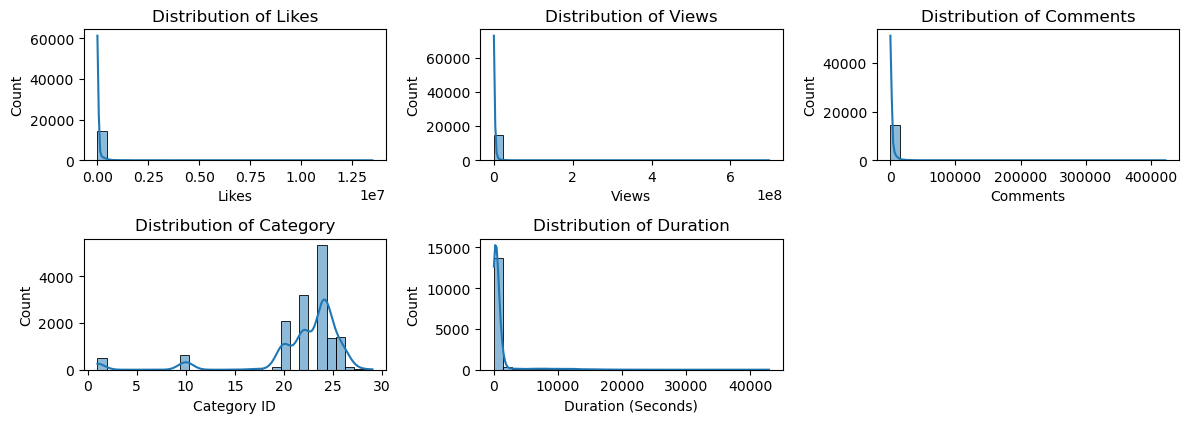

In [96]:
# Distribution of 'Likes', 'Views', 'Comments'
plt.figure(figsize=(12, 6))

plt.subplot(3, 3, 1)
sns.histplot(df['Likes'], bins=30, kde=True)
plt.title('Distribution of Likes')

plt.subplot(3, 3, 2)
sns.histplot(df['Views'], bins=30, kde=True)
plt.title('Distribution of Views')

plt.subplot(3, 3, 3)
sns.histplot(df['Comments'], bins=30, kde=True)
plt.title('Distribution of Comments')

plt.subplot(3, 3, 4)
sns.histplot(df['Category ID'], bins=30, kde=True)
plt.title('Distribution of Category')

plt.subplot(3, 3, 5)
sns.histplot(df['Duration (Seconds)'], bins=30, kde=True)
plt.title('Distribution of Duration')

plt.tight_layout()
plt.show()

/Users/nidhikulkarni/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nidhikulkarni/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


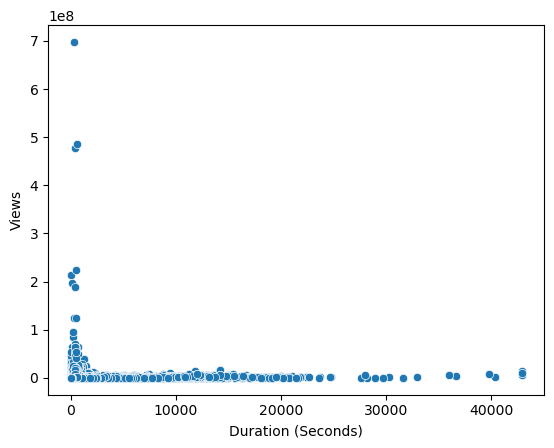

/Users/nidhikulkarni/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nidhikulkarni/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


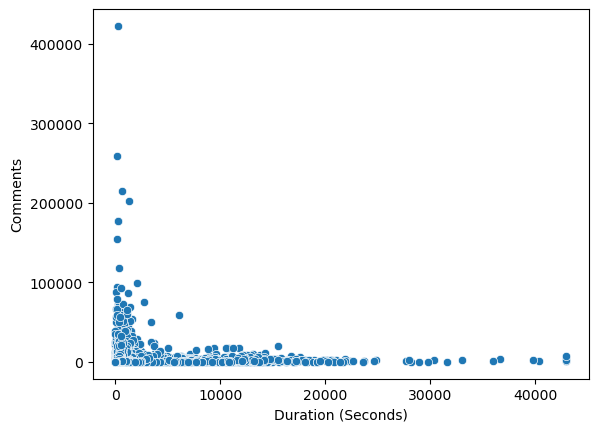

/Users/nidhikulkarni/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nidhikulkarni/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


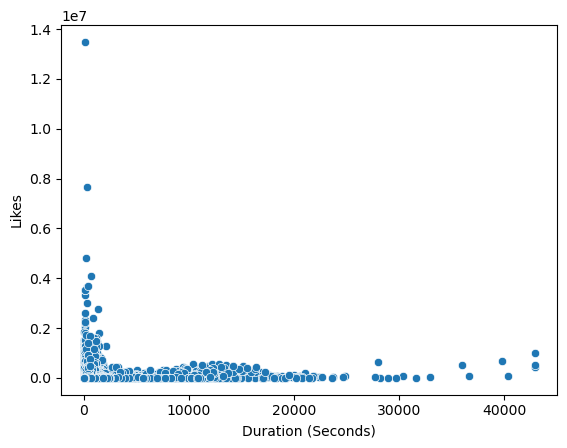

/Users/nidhikulkarni/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nidhikulkarni/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nidhikulkarni/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


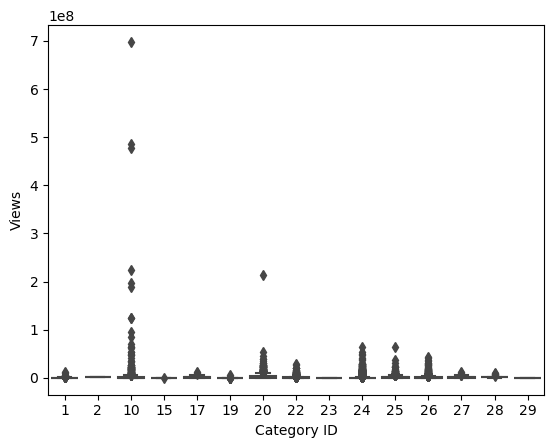

/Users/nidhikulkarni/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nidhikulkarni/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nidhikulkarni/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


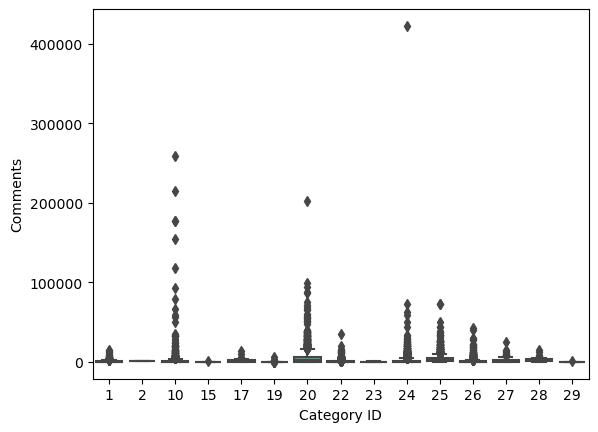

/Users/nidhikulkarni/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nidhikulkarni/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nidhikulkarni/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


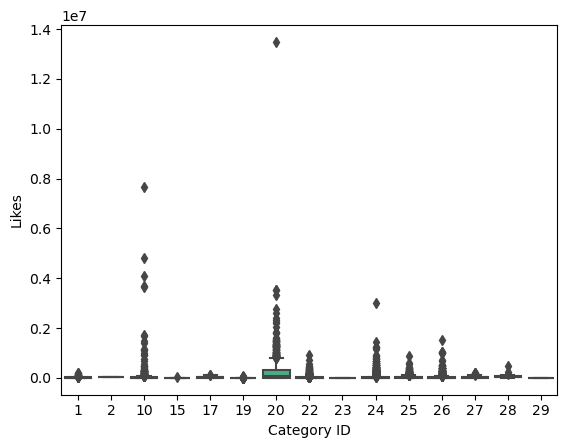

In [97]:
#sns.scatterplot(data=df, x='Duration (Seconds)', y='Views')
#plt.show()

sns.scatterplot(data=df, x='Duration (Seconds)', y='Views')
plt.show()

sns.scatterplot(data=df, x='Duration (Seconds)', y='Comments')
plt.show()

sns.scatterplot(data=df, x='Duration (Seconds)', y='Likes')
plt.show()

sns.boxplot(x='Category ID', y='Views', data=df)
plt.show()

sns.boxplot(x='Category ID', y='Comments', data=df)
plt.show()

sns.boxplot(x='Category ID', y='Likes', data=df)
plt.show()

Feature Engineering
duration is to be binned as short, medium, long and very_long

In [98]:
# Binning example
df['duration_bin'] = pd.cut(df['Duration (Seconds)'], bins=[0, 180, 600, 1800, max(df['Duration (Seconds)'])], labels=['short', 'medium', 'long', 'very_long'])


/Users/nidhikulkarni/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/nidhikulkarni/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Category ID')

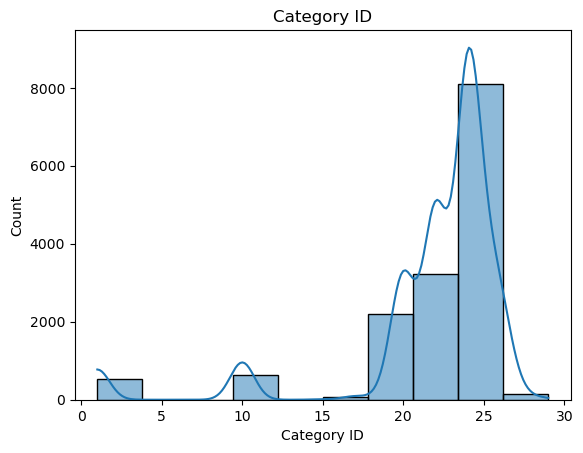

In [109]:
#sns.histplot(df['duration_bin'], bins=30, kde=True)
#plt.title('Duration Bin')

sns.histplot(df['Category ID'], bins = 10, kde=True)
plt.title('Category ID')

anova testing

the duration of a video does have an effect on the number of likes it receives, according to the data

The very low P-value (3.660633e-35) indicates that the likelihood of seeing at least this much difference in likes purely due to random chance is extremely low. Therefore, we can infer that video duration is not independent of the number of likes; there is a dependency or a relationship between these two variables.

In [100]:
anova_model = ols('Likes ~ C(duration_bin)', data=df).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)

print(anova_table)

                       sum_sq       df          F        PR(>F)
C(duration_bin)  1.107366e+13      3.0  82.569359  5.621706e-53
Residual         6.665885e+14  14911.0        NaN           NaN


In [101]:
anova_model = ols('Views ~ C(duration_bin)', data=df).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)

print(anova_table)

                       sum_sq       df          F        PR(>F)
C(duration_bin)  4.423171e+15      3.0  16.197452  1.654531e-10
Residual         1.357290e+18  14911.0        NaN           NaN


In [102]:
anova_model = ols('Comments ~ C(duration_bin)', data=df).fit()
anova_table = sm.stats.anova_lm(anova_model, typ=2)

print(anova_table)

                       sum_sq       df           F        PR(>F)
C(duration_bin)  2.138020e+10      3.0  136.313671  3.966823e-87
Residual         7.795748e+11  14911.0         NaN           NaN


       Multiple Comparison of Means - Tukey HSD, FWER=0.05        
group1   group2    meandiff  p-adj     lower       upper    reject
------------------------------------------------------------------
  long    medium -67841.3494    0.0 -79648.4799 -56034.2188   True
  long     short -61872.7176    0.0 -74366.2664 -49379.1687   True
  long very_long -30894.5727 0.0002 -49787.1153 -12002.0302   True
medium     short   5968.6318 0.4779  -4724.1323  16661.3958  False
medium very_long  36946.7766    0.0   19193.619  54699.9342   True
 short very_long  30978.1449 0.0001  12761.2561  49195.0337   True
------------------------------------------------------------------
          Multiple Comparison of Means - Tukey HSD, FWER=0.05          
group1   group2     meandiff   p-adj      lower        upper     reject
-----------------------------------------------------------------------
  long    medium  -469449.1231 0.1066 -1002233.8253   63335.5792  False
  long     short -1428491.0258    0.0 -199

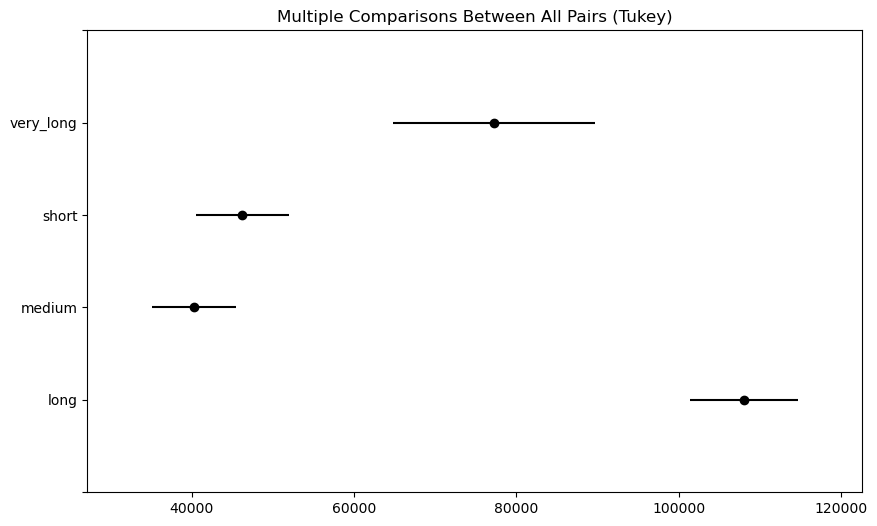

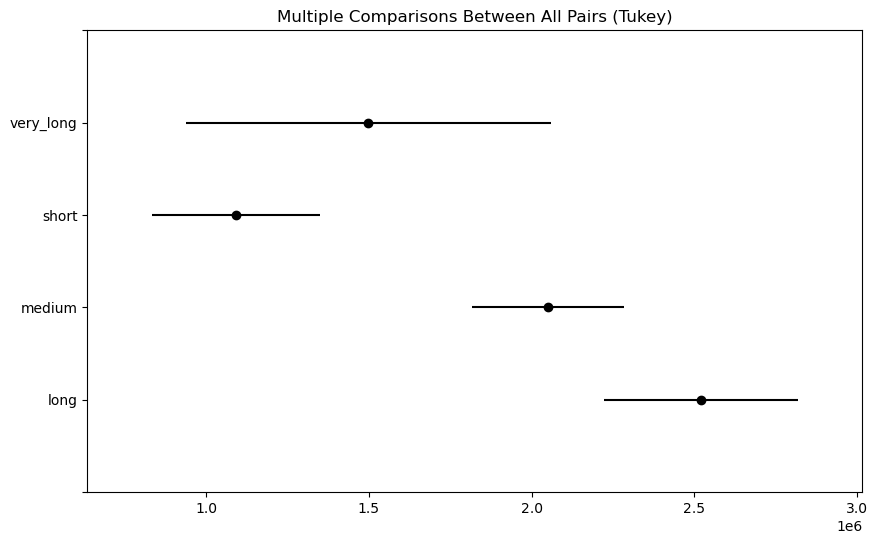

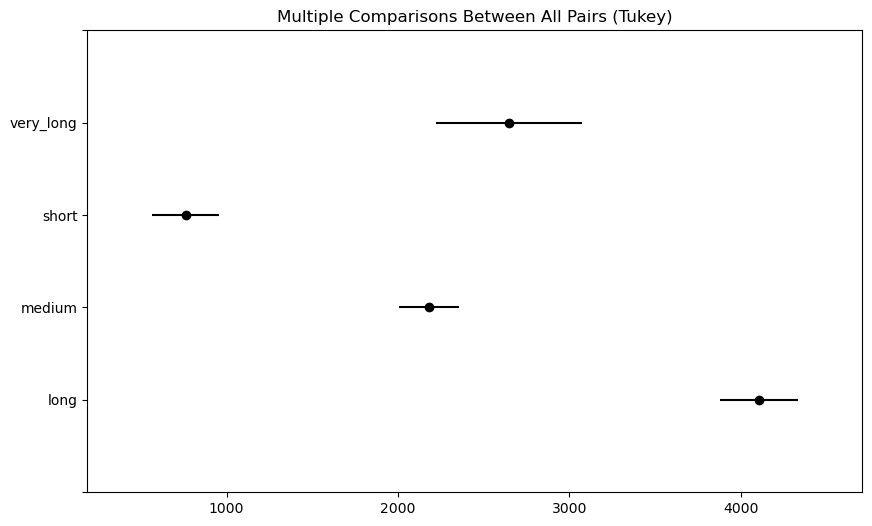

In [103]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

df['duration_bin'] = df['duration_bin'].astype('category')
# Make sure 'Likes', 'Views', and 'Comments' are numeric (float or int)
df['Likes'] = pd.to_numeric(df['Likes'], errors='coerce')
df['Views'] = pd.to_numeric(df['Views'], errors='coerce')
df['Comments'] = pd.to_numeric(df['Comments'], errors='coerce')
df = df.dropna(subset=['duration_bin', 'Likes', 'Views', 'Comments'])

# Assuming 'df' is your DataFrame with a 'duration_bin' column and the metric columns

# Post hoc analysis for 'Likes'
tukey_likes = pairwise_tukeyhsd(endog=df['Likes'],      # Data
                                groups=df['duration_bin'],  # Groups
                                alpha=0.05)               # Significance level

# Post hoc analysis for 'Views'
tukey_views = pairwise_tukeyhsd(endog=df['Views'],      # Data
                                groups=df['duration_bin'],  # Groups
                                alpha=0.05)               # Significance level

# Post hoc analysis for 'Comments'
tukey_comments = pairwise_tukeyhsd(endog=df['Comments'],  # Data
                                   groups=df['duration_bin'],  # Groups
                                   alpha=0.05)               # Significance level

# Print the results
print(tukey_likes.summary())
print(tukey_views.summary())
print(tukey_comments.summary())

# You can also plot the results
tukey_likes.plot_simultaneous()
tukey_views.plot_simultaneous()
tukey_comments.plot_simultaneous()

plt.show()


medium and long videos are more likely impacting the engagement